# LDDMM: how To Bring Deformations from Subject-Specific Atlases Into the Tangent Space at the Global Atlas

- Load meshes:
  - Use DenseMaternalMeshLoader to load left hippocampus structure for all three subjects

- Create subject-specific pre-pregnancy atlases:
  - For each subject i:
    - Get pre-pregnancy meshes of left hippocampus
    - Compute subject-specific pre-pregnancy atlas $X_{i, \text{pre-pregnancy}}$.

- Create global pre-pregnancy atlas:
  - Compute global pre-pregnancy atlas from subject-specific pre-pregnancy atlases: $X^{\text{pre-pregnancy}} = \text{mean}_i ~~X^{\text{pre-pregnancy}}_{i}$.

- Extract pregnancy deformations as momenta:
  - For each subject i and pregnancy timepoint t:
    - Compute deformation from pre-pregnancy atlas to each pregnancy mesh, using control points of global atlas: $\text{deformation}_{it} = X^{\text{pre-pregnancy}}_{i} \rightarrow X^{\text{pregnancy}}_{it}$ as momenta at control points
    - Parallel transport deformation into global deterministic atlas space to get Xit: this is assumed to be the identity

- Build prediction model:
  - Use linear regression to predict gestational week (Yit=t) from transported deformations (Xit)

In [1]:
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import pyvista as pv

import polpo.lddmm as plddmm
import polpo.preprocessing.dict as ppdict
import polpo.preprocessing.pd as ppd
import polpo.utils as putils
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing.load.deformetrica import LoadMeshFlow
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader, TabularDataLoader
from polpo.preprocessing.mesh.decimation import PvDecimate
from polpo.preprocessing.mesh.io import DictMeshWriter, PvReader
from polpo.preprocessing.mesh.registration import RigidAlignment
from polpo.preprocessing.str import TryToInt

In [2]:
DEBUG = False
RECOMPUTE = True
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
SUBJECT_IDS = ["01", "1001B", "1004B"]#, "1009B"]#, "2004B"]

RESULTS_DIR = Path("results") / "regression_example"
ATLAS_DIR = RESULTS_DIR / "atlases"
MESHES_DIR = RESULTS_DIR / "meshes"
REGISTRATIONS_DIR = RESULTS_DIR / "registrations"
TRANSPORTS_DIR = RESULTS_DIR / "transports"
PARALLEL_SHOOT_DIR = RESULTS_DIR / "parallel_shoot"

if RESULTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(RESULTS_DIR)

data_dir = "/home/data/maternal" if putils.in_frank() else "~/.herbrain/data/maternal"

In [4]:
def _sub_id2name(sub_id):
    return f"sub_{sub_id}"

## Load, write and filter meshes

In [5]:
path2meshes = MeshLoader(
    subject_subset=SUBJECT_IDS,
    struct_subset=["L_Hipp"],
    derivative="fsl",
    as_mesh=True,
    data_dir=data_dir,
) + ppdict.ExtractUniqueKey(nested=True)


if DEBUG:
    path2meshes += ppdict.DictMap(ppdict.TruncateDict(n_keys=8))


# subject_id, session_id
raw_meshes = path2meshes()

print("Number of meshes for:")
for subject_id, meshes in raw_meshes.items():
    print(f"  -subject {subject_id}: {len(meshes)}")

Number of meshes for:
  -subject 01: 27
  -subject 1001B: 14
  -subject 1004B: 22


In [6]:
csvs = {}
for subject_id in SUBJECT_IDS:
    csvs[subject_id] = TabularDataLoader(data_dir=data_dir, subject_id=subject_id)()

for subject_id in SUBJECT_IDS:
    print(subject_id)
    display(csvs[subject_id])

01


,estro,prog,lh,gestWeek,stage,EndoStatus,trimester
sessionID,,,,,,,
1,NaN,NaN,NaN,-3.0,pre,pilot1,pre
2,3.42,0.840,NaN,-0.5,pre,pilot2,pre
3,386.00,NaN,NaN,1.0,pre,IVF,pre
4,1238.00,NaN,NaN,1.5,pre,IVF,pre
5,1350.00,2.940,NaN,2.0,pre,IVF,first
6,241.00,8.760,NaN,3.0,preg,Pregnant,first
7,NaN,NaN,NaN,9.0,preg,Pregnant,first
8,NaN,NaN,NaN,12.0,preg,Pregnant,first
9,NaN,NaN,NaN,14.0,preg,Pregnant,second


1001B


,gestWeek,stage,trimester,group,sex,age_at_conception
sessionID,,,,,,
base1,-18.0,pre,pre,pregnant,F,34.0
base2,-13.0,pre,pre,NaN,NaN,NaN
gest1,8.0,preg,first,NaN,NaN,NaN
gest2,13.0,preg,first,NaN,NaN,NaN
gest3,17.0,preg,second,NaN,NaN,NaN
gest4,22.0,preg,second,NaN,NaN,NaN
gest5,26.0,preg,second,NaN,NaN,NaN
gest6,30.0,preg,third,NaN,NaN,NaN
gest7,35.0,preg,third,NaN,NaN,NaN


1004B


,gestWeek,stage,trimester,group,sex,age_at_conception
sessionID,,,,,,
base1,-2.5,pre,pre,pregnant,F,26.0
base2,2.0,preg,first,NaN,NaN,NaN
gest1,5.0,preg,first,NaN,NaN,NaN
gest2,7.0,preg,first,NaN,NaN,NaN
gest3,8.5,preg,first,NaN,NaN,NaN
gest4,10.5,preg,first,NaN,NaN,NaN
gest5,12.5,preg,first,NaN,NaN,NaN
gest6,14.5,preg,second,NaN,NaN,NaN
gest7,16.5,preg,second,NaN,NaN,NaN


In [7]:
# Rigid alignment of all meshes to the first mesh of subject 01
align_pipe = RigidAlignment(
    target=putils.get_first(raw_meshes["01"]),
    # TODO: update here
    max_iterations=10,
)

# Coarsen all meshes to reduce number of vertices
# NB: this steps kills any correspondence between meshes
# TODO: evaluate relevance of this step
decimate_pipe = PvDecimate(target_reduction=0.6)


# TODO: it is better to go the other way around
rigidly_aligned_meshes = ppdict.DictMap(align_pipe)(raw_meshes)

meshes = ppdict.NestedDictMap(decimate_pipe)(rigidly_aligned_meshes)

2025-10-29 09:40:36.802 (   4.280s) [    7F8B78B22440]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


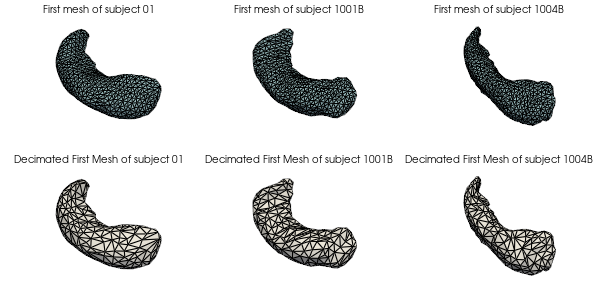

In [8]:
pl = pv.Plotter(shape=(2, 3), border=False, window_size=[600, 300])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0, i)
    pl.add_mesh(putils.get_first(rigidly_aligned_meshes[subject_id]), show_edges=True)
    pl.add_text(
        f"First mesh of subject {subject_id}", position="upper_edge", font_size=4
    )

    pl.subplot(1, i)
    pl.add_mesh(putils.get_first(meshes[subject_id]), show_edges=True, color="white")
    pl.add_text(
        f"Decimated First Mesh of subject {subject_id}",
        position="upper_edge",
        font_size=4,
    )

pl.show()

In [9]:
def _key2name(key):
    sub_id, session_id = key.split("/")
    return f"{_sub_id2name(sub_id)}/mesh_{session_id}"


meshes2files = (
    ppdict.UnnestDict(sep="/")
    + DictMeshWriter(dirname=MESHES_DIR, ext="vtk", key2name=_key2name)
    + ppdict.NestDict(sep="/")
    + ppdict.DictMap(ppdict.DictMap(key_step=TryToInt()))
)

# subject, session: filename
dataset = meshes2files(meshes)

## Estimate deterministic atlas for subject and global

Compute subject specific deterministic atlas by averaging pre-pregnancy meshes.

First, we select the pre-pregnancy meshes.

In [10]:
# TODO: update here
pre_keys_selector = ppd.DfIsInFilter("stage", ["pre"]) + (lambda x: x.index)

pre_keys = ppdict.DictMap(pre_keys_selector)(csvs)

In [11]:
pre_dataset = {
    subject_id: ppdict.SelectKeySubset(pre_keys[subject_id])(meshes)
    for subject_id, meshes in dataset.items()
}

Closely follows [LDDMM: how to estimate a deterministic atlas?](./lddmm_deterministic_atlas.ipynb).

In [12]:
kernel_width = 10.0  # NB: influences the number of cp

registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    attachment_kernel_width=2.0,
    tol=1e-10,
)

In [13]:
templates = {}

for subject_id, dataset_ in pre_dataset.items():
    output_dir = ATLAS_DIR / _sub_id2name(subject_id)
    if output_dir.exists():
        templates[subject_id] = plddmm.io.load_template(output_dir, as_path=True)
        continue

    templates[subject_id] = plddmm.learning.estimate_deterministic_atlas(
        targets=dataset_,
        output_dir=output_dir,
        initial_step_size=1e-1,
        **registration_kwargs,
    )


output_dir = ATLAS_DIR / "global"
if not output_dir.exists():
    templates["global"] = plddmm.learning.estimate_deterministic_atlas(
        targets=templates,
        output_dir=output_dir,
        initial_step_size=1e-1,
        **registration_kwargs,
    )
else:
    templates["global"] = plddmm.io.load_template(output_dir, as_path=True)


templates = ppdict.DictMap(PvReader())(templates)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/regression_example/atlases/sub_01/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimension': 3, 'optimization_method_type': 'ScipyLBFGS', 'convergence_tole

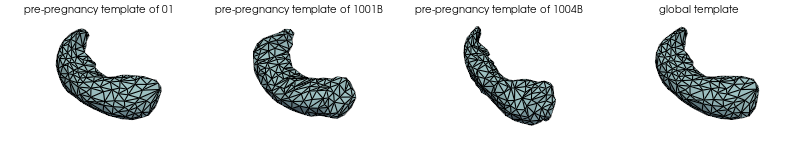

In [14]:
pl = pv.Plotter(shape=(1, 4), border=False, window_size=[800, 150])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0, i)
    pl.add_mesh(templates[subject_id], show_edges=True)
    pl.add_text(
        f"pre-pregnancy template of {subject_id}", position="upper_edge", font_size=4
    )

pl.subplot(0, 3)
pl.add_mesh(templates["global"], show_edges=True)
pl.add_text("global template", position="upper_edge", font_size=4)

pl.show()

## Parallel transport to atlas

Closely follows [LDDMM: parallel transport?](./lddmm_transport_abc.ipynb).

In [15]:
global_template = plddmm.io.load_template(ATLAS_DIR / "global", as_path=True)

for subject_id, meshes in dataset.items():
    subject_template = plddmm.io.load_template(
        ATLAS_DIR / f"sub_{subject_id}", as_path=True
    )
    transport_dir = TRANSPORTS_DIR / _sub_id2name(subject_id)
    registrations_dir = REGISTRATIONS_DIR / _sub_id2name(subject_id)
    parallel_shoot_dir = PARALLEL_SHOOT_DIR / _sub_id2name(subject_id)

    for session_id, mesh in meshes.items():
        transport_dir_sess = transport_dir / plddmm.io.build_parallel_transport_name(
            subject_id, "global", session_id
        )
        if transport_dir_sess.exists():
            continue

        meshes = {
            "global": global_template,
            subject_id: subject_template,
            session_id: mesh,
        }
        plddmm.geometry.parallel_transport_ABC(
            meshes,
            output_dir=transport_dir,
            registration_dir=registrations_dir,
            compute_shoot=True,
            shoot_dir=parallel_shoot_dir,
            use_pole_ladder=True,
            **registration_kwargs,
        )

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 20.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/regression_example/registrations/sub_01/01->global/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
instantiating kernel torch with kernel_width 20.0 and gpu_mode GpuMode.KERNEL. addr: 0x7f88d14ca5a0
>> Set of 4 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------
>> Gradient at Termination: 2524.9788413671886
>> ABNORMAL: 
>> Estimation took: 0

/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/in_out/dataset_functions.py:265: UserWarning: Watch out, I did not get a distance type for the object shape, Please make sure you are running shooting or a parallel transport, otherwise distances are required.
  warnings.warn(msg)


>> Gradient at Termination: 586.7095643285912
>> ABNORMAL: 
>> Estimation took: 01 seconds
Deformetrica.__del__()
source is ignored when pole ladder is used
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
[ compute_shooting function ]
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.
Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 20.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/regression_example/registrations/sub_01/01->3/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tri

## Visualize shooting from atlases to subject last mesh

From subject template.

In [16]:
meshes = {}

for subject_id, sessions in dataset.items():
    registrations_dir = (
        REGISTRATIONS_DIR
        / _sub_id2name(subject_id)
        / plddmm.io.build_registration_name(
            subject_id,
            list(sessions.keys())[-1],
        )
    )
    print(registrations_dir)
    meshes[subject_id] = plddmm.io.load_deterministic_atlas_flow(
        registrations_dir, as_pv=True
    )

results/regression_example/registrations/sub_01/01->27
results/regression_example/registrations/sub_1001B/1001B->post5
results/regression_example/registrations/sub_1004B/1004B->post7


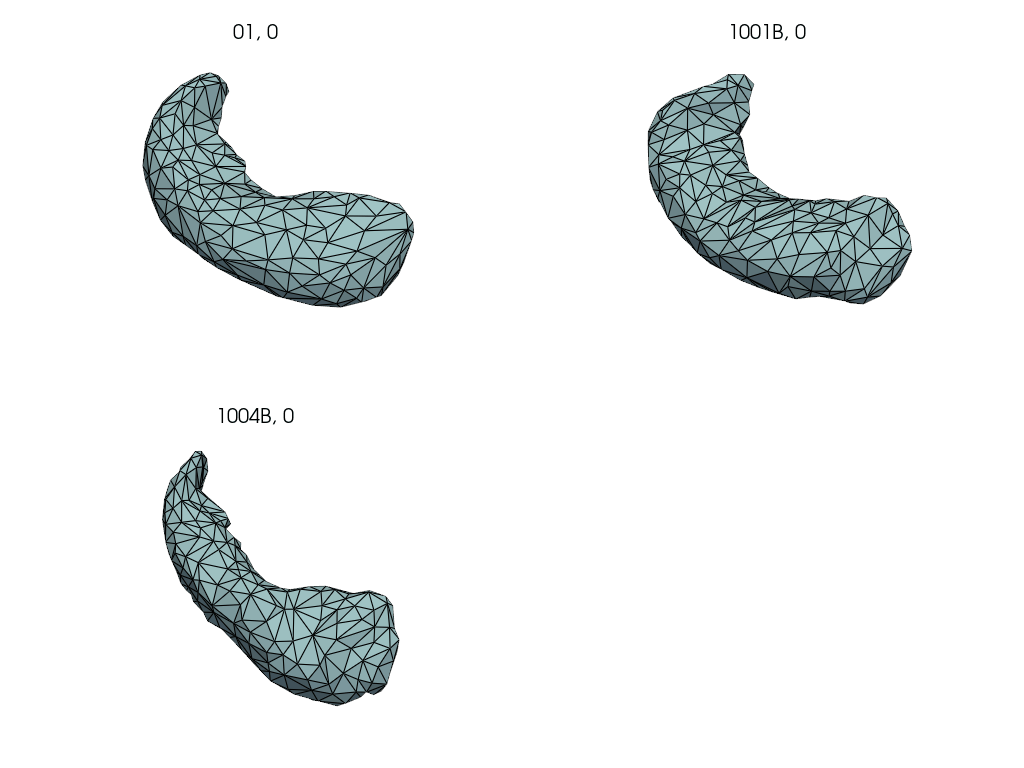

In [17]:
pl = RegisteredMeshesGifPlotter(
    subtitle=lambda time, subj: f"{subj}, {time}",
    shape=(2, 2),
    fps=5,
)

pl.add_meshes(ppdict.DictListSwapper()(meshes))
pl.close()

pl.show()

From global template.

In [18]:
meshes = {}

for subject_id, sessions in dataset.items():
    parallel_shoot_dir = (
        PARALLEL_SHOOT_DIR
        / _sub_id2name(subject_id)
        / plddmm.io.build_parallel_shoot_name(
            subject_id,
            "global",
            list(sessions.keys())[-1],
        )
    )
    print(parallel_shoot_dir)
    # TODO: clean io
    meshes[subject_id] = LoadMeshFlow(as_path=False)(parallel_shoot_dir)

results/regression_example/parallel_shoot/sub_01/global(t01>27)
results/regression_example/parallel_shoot/sub_1001B/global(t1001B>post5)
results/regression_example/parallel_shoot/sub_1004B/global(t1004B>post7)


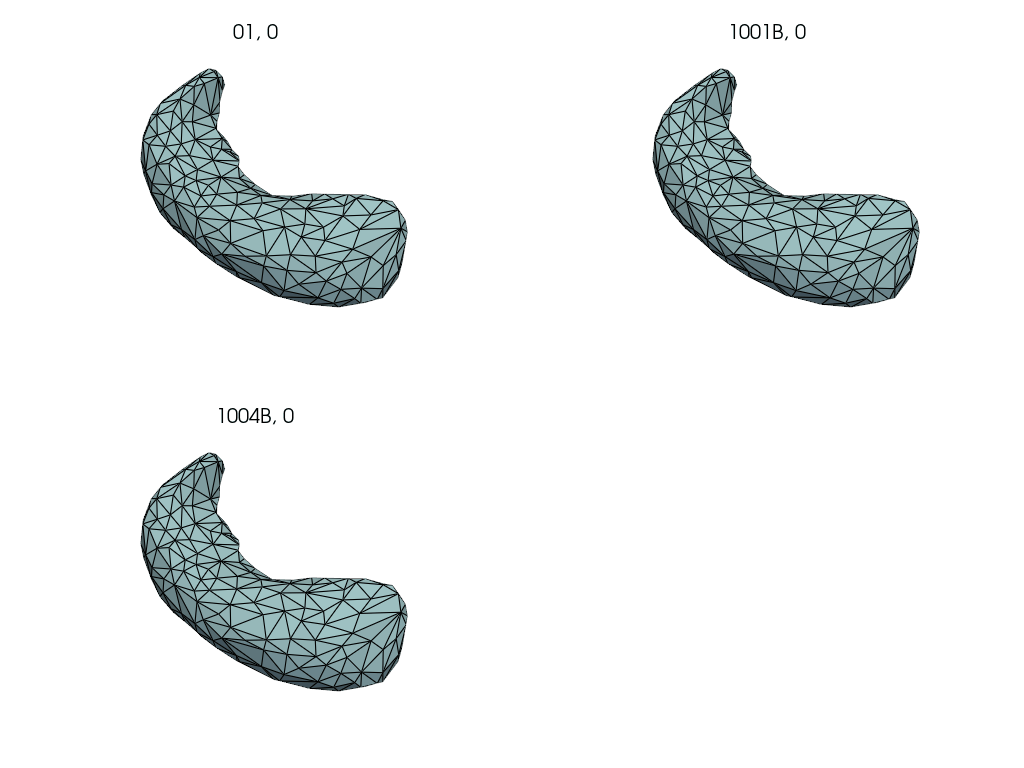

In [19]:
pl = RegisteredMeshesGifPlotter(
    subtitle=lambda time, subj: f"{subj}, {time}",
    shape=(2, 2),
    fps=5,
)

pl.add_meshes(ppdict.NestedDictSwapper()(meshes))
pl.close()

pl.show()

In [20]:
last_meshes = [list(meshes.values())[-1] for meshes in meshes.values()]

(
    np.amax(np.abs(last_meshes[0].points - last_meshes[1].points)),
    np.amax(np.abs(last_meshes[0].points - last_meshes[2].points)),
)

(np.float64(1.0626754760742188), np.float64(1.0740966796875))

# Compute velocities

In [21]:
plddmm.io.load_cp(ATLAS_DIR / "global", as_path=True)

PosixPath('results/regression_example/atlases/global/DeterministicAtlas__EstimatedParameters__ControlPoints.txt')

In [22]:
cp = {}
momenta = {}
vel = {}

atlas_cp = plddmm.io.load_cp(ATLAS_DIR / "global", as_path=False)

for subject_id, meshes in dataset.items():
    transport_dir = TRANSPORTS_DIR / _sub_id2name(subject_id)
    cp_subj = cp[subject_id] = {}
    momenta_subj = momenta[subject_id] = {}
    vel_subj = vel[subject_id] = {}

    for session_id, mesh in meshes.items():
        transport_dir_sess = transport_dir / plddmm.io.build_parallel_transport_name(
            subject_id, "global", session_id
        )

        cp_ = cp_subj[session_id] = plddmm.io.load_transported_cp(
            transport_dir_sess, as_path=False
        )
        momenta_ = momenta_subj[session_id] = plddmm.io.load_transported_momenta(
            transport_dir_sess, as_path=False
        )

        vel_subj[session_id] = plddmm.geometry.velocity_at_x(
            atlas_cp, cp_, momenta_, kernel_width=kernel_width
        )

Velocities are comparable quantities.

In [23]:
vel_week = {}

for subject_id, subj_dict in vel.items():
    session2week = csvs[subject_id]["gestWeek"]
    vel_week[subject_id] = ppdict.DictMap(
        key_step=lambda session: float(session2week[session])
    )(vel[subject_id])

vel_ls = []
for subj_id, subj_vel in vel_week.items():
    for week, vels in subj_vel.items():
        vel_ls.append(
            {
                "subject": subj_id,
                "week": float(week),
                "vel": vels,
            }
        )

In [24]:
df = pd.DataFrame.from_dict(vel_ls)

df.to_csv(RESULTS_DIR / "velocities.csv", index=False)

In [25]:
vel_week

{'01': {-3.0: array([[ 0.00220195,  0.05142251, -0.04584359],
         [ 0.00203441,  0.04553534, -0.0403849 ],
         [ 0.01117069,  0.04208901, -0.01480857],
         [ 0.01141505,  0.04095323, -0.01308329],
         [ 0.02461177,  0.05242203,  0.0074419 ],
         [ 0.02654672,  0.05643063,  0.00816343],
         [-0.00952978,  0.04259073, -0.04397725],
         [-0.00891005,  0.03932984, -0.04048735],
         [ 0.00771329,  0.03920534, -0.01333026],
         [ 0.0095078 ,  0.04198331, -0.01236233],
         [ 0.0284091 ,  0.05524097,  0.00706629],
         [ 0.03281986,  0.06477229,  0.00868083],
         [-0.07927734, -0.06910087,  0.02113093],
         [-0.07929646, -0.06957772,  0.02156907],
         [-0.02039247, -0.01452065,  0.0096149 ],
         [-0.01966953, -0.01373022,  0.00965709],
         [ 0.03515238,  0.0403994 ,  0.00036235],
         [ 0.03712611,  0.04236589,  0.00033238],
         [-0.07195229, -0.06915385,  0.02503579],
         [-0.07260469, -0.0697768 ,  0

In [26]:
vel_week

{'01': {-3.0: array([[ 0.00220195,  0.05142251, -0.04584359],
         [ 0.00203441,  0.04553534, -0.0403849 ],
         [ 0.01117069,  0.04208901, -0.01480857],
         [ 0.01141505,  0.04095323, -0.01308329],
         [ 0.02461177,  0.05242203,  0.0074419 ],
         [ 0.02654672,  0.05643063,  0.00816343],
         [-0.00952978,  0.04259073, -0.04397725],
         [-0.00891005,  0.03932984, -0.04048735],
         [ 0.00771329,  0.03920534, -0.01333026],
         [ 0.0095078 ,  0.04198331, -0.01236233],
         [ 0.0284091 ,  0.05524097,  0.00706629],
         [ 0.03281986,  0.06477229,  0.00868083],
         [-0.07927734, -0.06910087,  0.02113093],
         [-0.07929646, -0.06957772,  0.02156907],
         [-0.02039247, -0.01452065,  0.0096149 ],
         [-0.01966953, -0.01373022,  0.00965709],
         [ 0.03515238,  0.0403994 ,  0.00036235],
         [ 0.03712611,  0.04236589,  0.00033238],
         [-0.07195229, -0.06915385,  0.02503579],
         [-0.07260469, -0.0697768 ,  0

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = [] 
y = [] 

subjects_ids = ["1004B", "1001B"]

for subject_id in subjects_ids:
    subject_data = vel_week[subject_id]

    for gest_week, velocity_matrix in subject_data.items():
        # print(velocity_matrix)
        # print(gest_week)
        X.append(gest_week)
        y.append(velocity_matrix.flatten())

X = np.array(X).reshape(-1, 1)
y = np.array(y)

print(f"shape of feature matrix X (weeks): {X.shape}")
print(f"shape of target matrix y (flattened velocities): {y.shape}")



shape of feature matrix X (weeks): (36, 1)
shape of target matrix y (flattened velocities): (36, 72)


In [28]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# try regular linear regression with velocities -- still bad r2 values

model = LinearRegression()
model.fit(X_train, y_train)

print(f"shape of  coefficients (slopes): {model.coef_.shape}")
print(f"shape of model intercept: {model.intercept_.shape}")

# Evaluate the model on the test set
test_score = model.score(X_test, y_test)
print(f"\nR2 score on the test set: {test_score:.3f}")


shape of  coefficients (slopes): (72, 1)
shape of model intercept: (72,)

R2 score on the test set: -0.035


In [29]:
X_train_list = []
y_train_list = []
subjects_to_train = ["1004B",]# "1001B"] 
# wait i don't remember why i tried training on just one subject

for subject_id in subjects_to_train:
  subject_data = vel_week[subject_id]
  for gest_week, velocity_matrix in subject_data.items():
      X_train_list.append(gest_week)
      y_train_list.append(velocity_matrix.flatten())

# test data from subject 01
X_test_list = []
y_test_list = []
subject_to_test = "01"
subject_data_test = vel_week[subject_to_test]
for gest_week, velocity_matrix in subject_data_test.items():
  X_test_list.append(gest_week)
  y_test_list.append(velocity_matrix.flatten())


X_train = np.array(X_train_list).reshape(-1, 1)
y_train = np.array(y_train_list)
X_test = np.array(X_test_list).reshape(-1, 1)
y_test = np.array(y_test_list)

print(f"shape of training feature matrix X (weeks): {X_train.shape}")
print(f"shape of training target matrix y (vlocities): {y_train.shape}")
print(f"shape of test feature matrix X (week): {X_test.shape}")
print(f"shape of test target matrix y (velocities): {y_test.shape}")

# now trying nonlinear regression (and ridge for overfitting)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
n_knots = 4  
degree = 3  

model = make_pipeline(
    SplineTransformer(n_knots=n_knots, degree=degree),
    LinearRegression()
)

# model = Ridge(alpha=1.0) 
# model = LinearRegression()
model.fit(X_train, y_train)


# still terrible R2
test_score = model.score(X_test, y_test)
print(f"\nR2 score on the test set (Subject '01'): {test_score:.3f}")



shape of training feature matrix X (weeks): (22, 1)
shape of training target matrix y (vlocities): (22, 72)
shape of test feature matrix X (week): (26, 1)
shape of test target matrix y (velocities): (26, 72)

R2 score on the test set (Subject '01'): -1.761


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, str

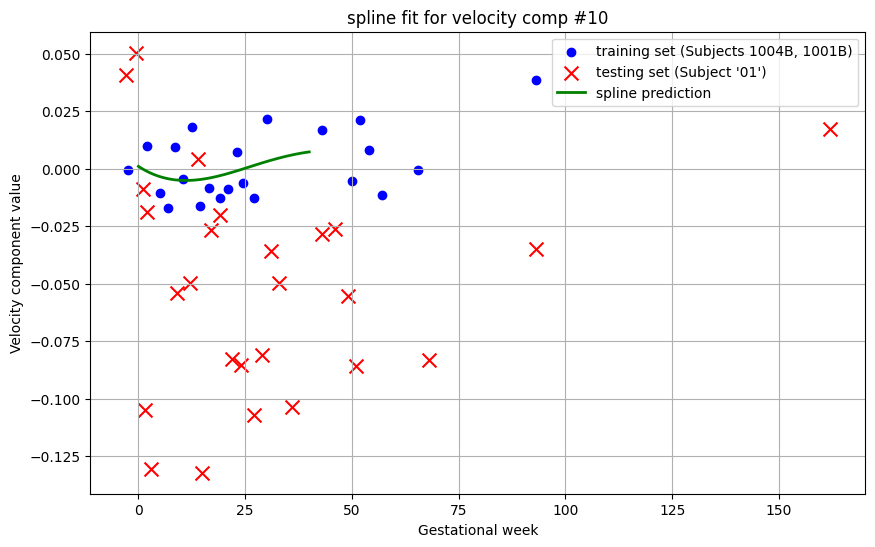

In [30]:
import matplotlib.pyplot as plt
component_to_plot = 10 # picked 10 for no reason in particular but wanted to plot something simple rather than 72 plots for each velocity and each dimension

X_plot = np.linspace(0, 40, 100).reshape(-1, 1)
y_plot_pred = model.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train[:, component_to_plot], label='training set (Subjects 1004B, 1001B)', c='blue')
plt.scatter(X_test, y_test[:, component_to_plot], label="testing set (Subject '01')", c='red', marker='x', s=100)
plt.plot(X_plot, y_plot_pred[:, component_to_plot], color='green', linewidth=2, label='spline prediction')

plt.title(f'spline fit for velocity comp #{component_to_plot}')
plt.xlabel('Gestational week')
plt.ylabel('Velocity component value')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# now i am trying mixed effects models
# need to do more in depth analysis of regular linreg and spline reg than just looking at R2s, but for now i moved onto LME
all_data = []
for subject_id, subject_data in vel_week.items():
    for week, matrix in subject_data.items():
        # each row in the matrix is a control point's velocity vector
        for cp_index, velocity_vec in enumerate(matrix):
            all_data.append({
                "subject": subject_id,
                "week": week,
                "cp_index": cp_index,
                "value_x": velocity_vec[0],
                "value_y": velocity_vec[1],
                "value_z": velocity_vec[2]
            })

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


df = pd.DataFrame(all_data)
print("--- Reshaped Data (first 5 rows) ---")
print(df.head())



--- Reshaped Data (first 5 rows) ---
  subject  week  cp_index   value_x   value_y   value_z
0      01  -3.0         0  0.002202  0.051423 -0.045844
1      01  -3.0         1  0.002034  0.045535 -0.040385
2      01  -3.0         2  0.011171  0.042089 -0.014809
3      01  -3.0         3  0.011415  0.040953 -0.013083
4      01  -3.0         4  0.024612  0.052422  0.007442


In [33]:
df

,subject,week,cp_index,value_x,value_y,value_z
0,01,-3.0,0,0.002202,0.051423,-0.045844
1,01,-3.0,1,0.002034,0.045535,-0.040385
2,01,-3.0,2,0.011171,0.042089,-0.014809
3,01,-3.0,3,0.011415,0.040953,-0.013083
4,01,-3.0,4,0.024612,0.052422,0.007442
...,...,...,...,...,...,...
1483,1004B,93.0,19,-0.000731,0.000146,0.000213
1484,1004B,93.0,20,-0.003482,0.001033,0.000895
1485,1004B,93.0,21,-0.000172,0.000403,-0.000060
1486,1004B,93.0,22,0.000830,0.002317,-0.000977


In [ ]:

import statsmodels.formula.api as smf
# i get convergence warnings here

# filter for one specific control point to model
df_cp0 = df[df['cp_index'] == 0]

# Model for X component
lme_model_x = smf.mixedlm("value_x ~ week", data=df_cp0, groups="subject")
results_x = lme_model_x.fit()

# Model for Y component
lme_model_y = smf.mixedlm("value_y ~ week", data=df_cp0, groups="subject")
results_y = lme_model_y.fit()

# Model for Z component
lme_model_z = smf.mixedlm("value_z ~ week", data=df_cp0, groups="subject")
results_z = lme_model_z.fit()


/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [35]:
X_pred = pd.DataFrame({'week': [25]})

pred_x = results_x.predict(X_pred)[0]
pred_y = results_y.predict(X_pred)[0]
pred_z = results_z.predict(X_pred)[0]

predicted_3d_vector = [pred_x, pred_y, pred_z]
print(f"predicted velocity at week 25: {predicted_3d_vector}")

predicted velocity at week 25: [np.float64(-0.1100075156282499), np.float64(0.06282665386116554), np.float64(0.07686207842449523)]


In [36]:
print(results_x.summary())

        Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: value_x
No. Observations:  62      Method:             REML   
No. Groups:        3       Scale:              0.0227 
Min. group size:   14      Log-Likelihood:     18.9563
Max. group size:   26      Converged:          Yes    
Mean group size:   20.7                               
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   -0.107    0.056 -1.910 0.056 -0.217  0.003
week        -0.000    0.001 -0.168 0.867 -0.001  0.001
subject Var  0.007    0.056                           



In [37]:
print(results_y.summary())
# higher order mixed effects? again, need to do more analysis but just tried it for fun
lme_model_y_quad = smf.mixedlm("value_y ~ week + I(week**2)", data=df_cp0, groups="subject")
results_y_quad = lme_model_y_quad.fit()
print(results_y_quad.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value_y
No. Observations: 62      Method:             REML   
No. Groups:       3       Scale:              0.0202 
Min. group size:  14      Log-Likelihood:     22.7625
Max. group size:  26      Converged:          Yes    
Mean group size:  20.7                               
-----------------------------------------------------
             Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept    0.057    0.046 1.232 0.218 -0.034  0.148
week         0.000    0.001 0.381 0.703 -0.001  0.001
subject Var  0.004    0.039                          

         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: value_y
No. Observations:   62      Method:             REML   
No. Groups:         3       Scale:              0.0191 
Min. group size:    14      Log-Likelihood:     14.2319
Max. group size:    26      Conver

/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
results_summary = []
control_point_indices = df['cp_index'].unique()

# here i also get convergence warnings
# now i do this for each control point
# i need to figure out how to do multivariate
for cp_index in control_point_indices:
    df_cp = df[df['cp_index'] == cp_index]
    
    try:
        p_x = smf.mixedlm("value_x ~ week", df_cp, groups="subject").fit().pvalues['week']
        p_y = smf.mixedlm("value_y ~ week", df_cp, groups="subject").fit().pvalues['week']
        p_z = smf.mixedlm("value_z ~ week", df_cp, groups="subject").fit().pvalues['week']
        
        results_summary.append({
            'cp_index': cp_index,
            'p_value_x': p_x,
            'p_value_y': p_y,
            'p_value_z': p_z,
            'min_p_value': min(p_x, p_y, p_z)
        })
    except Exception as e:
        print(f"can't fit model for cp {cp_index}: {e}")

df_results = pd.DataFrame(results_summary)
best_result = df_results.loc[df_results['min_p_value'].idxmin()]

best_cp_index = int(best_result['cp_index'])
print("\n--- most significant ---")
print(best_result)
print(f"\nbest CP is #{best_cp_index}")

Analyzing 24 control points...


/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packag

/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packag


--- most significant ---
cp_index       20.000000
p_value_x       0.000008
p_value_y       0.004790
p_value_z       0.230180
min_p_value     0.000008
Name: 20, dtype: float64

best CP is #20


/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packa

/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0.
findfont: score(FontEntry(fname='/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
findfont: score(FontEntry(fname='/home/sak/anaconda3/envs/deformetrica/lib/python3.12/site-packages/matplotl

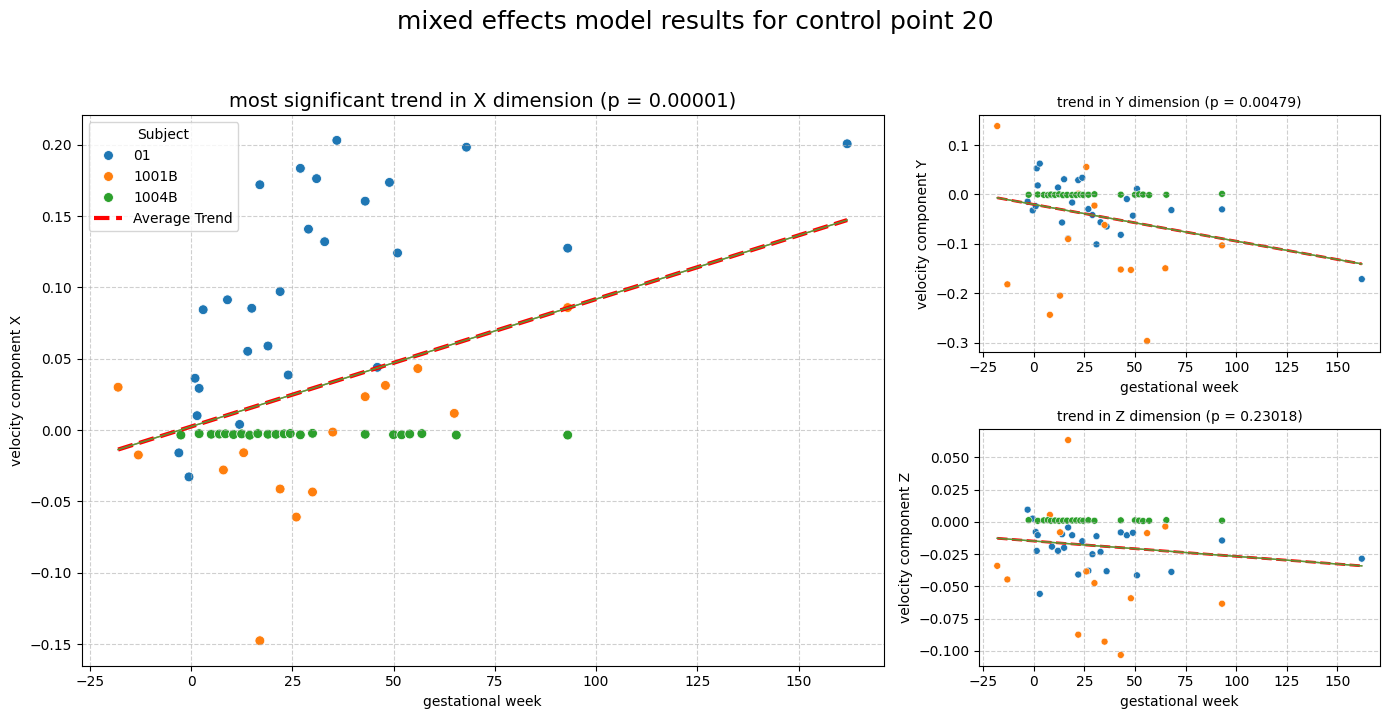

In [39]:
import seaborn as sns
# oh yeah, i installed this package

cp_to_plot = best_cp_index
df_plot = df[df['cp_index'] == cp_to_plot]

# determine which dimension had the minimum p-value
best_dim_info = best_result[['p_value_x', 'p_value_y', 'p_value_z']].idxmin()
main_dim_col = best_dim_info.replace('p_value_', 'value_') # e.g., 'value_y'
main_dim_label = main_dim_col[-1].upper() # e.g., 'Y'


model_x = smf.mixedlm(f"value_x ~ week", df_plot, groups="subject").fit()
model_y = smf.mixedlm(f"value_y ~ week", df_plot, groups="subject").fit()
model_z = smf.mixedlm(f"value_z ~ week", df_plot, groups="subject").fit()
models = {'X': model_x, 'Y': model_y, 'Z': model_z}

fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

ax_main = fig.add_subplot(gs[:, 0])

ax_sub1 = fig.add_subplot(gs[0, 1])
ax_sub2 = fig.add_subplot(gs[1, 1])


def plot_model_fit(ax, model, data, dim_label, is_main_plot=False):
    value_col = f'value_{dim_label.lower()}'
    p_value = model.pvalues['week']
    
    sns.scatterplot(data=data, x='week', y=value_col, hue='subject', ax=ax, legend=is_main_plot, s=(50 if is_main_plot else 25))

    x_range = pd.DataFrame({'week': np.linspace(data['week'].min(), data['week'].max(), 100)})
    
    # plot average trend
    y_avg = model.predict(x_range)
    ax.plot(x_range['week'], y_avg, color='red', linestyle='--', linewidth=(3 if is_main_plot else 2), label='Average Trend')
    
    # plot subject specific trends
    for subject_id in data['subject'].unique():
        x_subj = x_range.copy()
        x_subj['subject'] = subject_id
        y_subj = model.predict(x_subj)
        subj_color = sns.color_palette(n_colors=data['subject'].nunique())[list(data['subject'].unique()).index(subject_id)]
        ax.plot(x_subj['week'], y_subj, color=subj_color, linewidth=1, alpha=0.7)
        
    title_str = f'trend in {dim_label} dimension'
    if is_main_plot:
        title_str = f'most significant trend in {dim_label} dimension'
    ax.set_title(f'{title_str} (p = {p_value:.5f})', fontsize=(14 if is_main_plot else 10))
    ax.set_ylabel(f'velocity component {dim_label}')
    ax.set_xlabel('gestational week')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    if is_main_plot:
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = {}
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                unique_labels[label] = handle
        ax.legend(unique_labels.values(), unique_labels.keys(), title='Subject')


plot_model_fit(ax_main, models[main_dim_label], df_plot, main_dim_label, is_main_plot=True)

sub_dims = [dim for dim in ['X', 'Y', 'Z'] if dim != main_dim_label]
plot_model_fit(ax_sub1, models[sub_dims[0]], df_plot, sub_dims[0])
plot_model_fit(ax_sub2, models[sub_dims[1]], df_plot, sub_dims[1])


fig.suptitle(f'mixed effects model results for control point {cp_to_plot}', fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

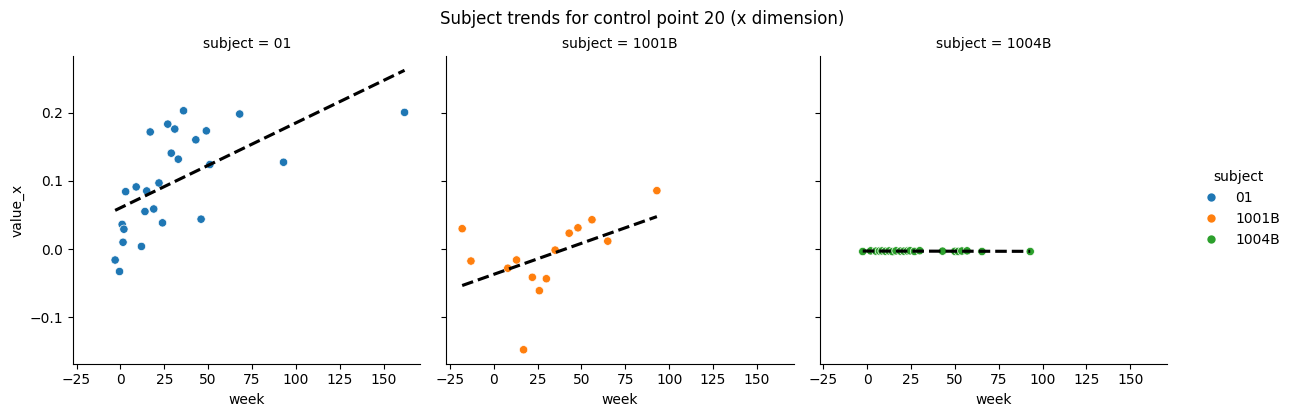

In [40]:
df_plot = df[df['cp_index'] == 20] 

g = sns.relplot(
    data=df_plot,
    x="week",
    y="value_x",
    hue="subject",  
    col="subject",  
    kind="scatter",
    height=4,
    aspect=1,
)

g.map(sns.regplot, "week", "value_x", scatter=False, ci=None, line_kws={'color':'black', 'linestyle':'--'})

g.fig.suptitle("Subject trends for control point 20 (x dimension)", y=1.03)
plt.show()

In [41]:
# was googling about how to evaluate mixed effects models and apparently regular r2 doesn't make sense so chatgpt made this function for me
def calculate_r2_mixed(model):

    """
    Calculates Marginal and Conditional R-squared for a statsmodels MixedLM object.
    This corrected version robustly calculates the fixed-effects variance.

    Args:
        model: A fitted MixedLM results object.

    Returns:
        A dictionary containing the marginal and conditional R-squared values.
    """
    # Variance of the fixed effects component
    # This is the variance of the predictions based ONLY on the fixed effects
    # It's the dot product of the design matrix (X) and the fixed-effect coefficients (beta)
    var_fixed = np.var(np.dot(model.model.exog, model.fe_params))

    # Variance of the random effects component (same as before)
    var_random = float(model.cov_re.iloc[0, 0])

    # Variance of the residuals (same as before)
    var_residual = model.scale

    # Total variance is the sum of all components
    var_total = var_fixed + var_random + var_residual

    # Marginal R-squared (variance explained by fixed effects)
    r2_marginal = var_fixed / var_total

    # Conditional R-squared (variance explained by fixed and random effects)
    r2_conditional = (var_fixed + var_random) / var_total

    return {
        "marginal_r2": r2_marginal,
        "conditional_r2": r2_conditional
    }

In [42]:
r2_values = calculate_r2_mixed(results_x)

print(f"R-squared for the model:")
print(f"  - Marginal R² (Fixed effects only): {r2_values['marginal_r2']:.5f}")
print(f"  - Conditional R² (Fixed + Random effects): {r2_values['conditional_r2']:.5f}")

R-squared for the model:
  - Marginal R² (Fixed effects only): 0.00034
  - Conditional R² (Fixed + Random effects): 0.24078
